In [1]:
import numpy as np
from emittance_calc import *

In [2]:
# data
#-5.38210006,
quad = [ -4.24154984, -3.71824052, -3.17573903, -2.5, -1.99949716] 
#1.59568569e-04,
xrms = [ 8.75908038e-05, 8.55396626e-05, 4.85704395e-05, 6e-5, 7.99284069e-05]
#quad = [-5.38210006, -4.24154984, -3.71824052, -3.17573903, -1.99949716] 
#xrms = [1.59568569e-04, 8.75908038e-05, 6.55396626e-05, 4.85704395e-05, 7.99284069e-05]
xerr = 0.1*np.array(xrms)#[ 0.3*8.75908038e-05, 0.2*8.55396626e-05, 0.3*4.85704395e-05, 0.5*6e-5, 0.2*7.99284069e-05]
#9.65669677e-05,


yquad = [-5.38210006, -3.71824052, -3.17573903,  -1.99949716] 
yrms = [9.65669677e-05,  4.721770e-05, 4.2127438e-05, 5.86293035e-05]

#yquad = [-5.38210006, -4.24154984, -3.71824052, -3.17573903, -1.99949716] 
#yrms = [9.65669677e-05, 5.61440470e-05, 4.89721770e-05, 4.80127438e-05, 5.86293035e-05]
yerr = 0.1*np.array(yrms)
#yerr = [ 0.1*8.75908038e-05, 0.3*8.55396626e-05, 0.8*4.85704395e-05, 0.1*6e-5]

#18.31%, 22.38%, 24.30%
#0.7285878976068937 [[0.07941099]]

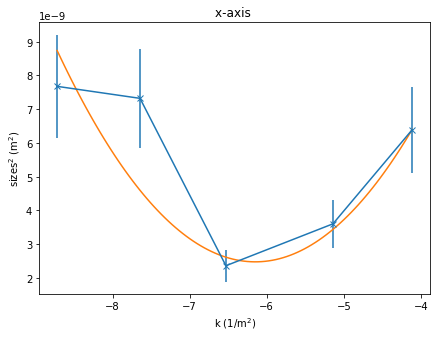

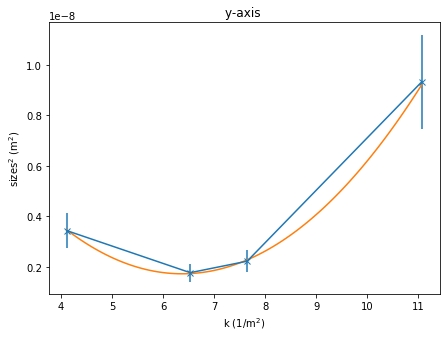

nemitx: 0.73, nemity: 0.37
nemitx_err: 0.11, nemity_err: 0.01
bmagx: 7.02, bmagy: 2.05
bmagx_err: 3.90, bmagy_err: 0.14


In [3]:
emittance = get_normemit(0.135, quad, yquad, xrms, np.array(yrms), xerr, yerr, adapt_ranges=False, show_plots=True)

In [ ]:
#import numpy.polynomial.polynomial as poly
import datetime
import numpy as np 
import warnings
import sys, os, errno

m_0 = 0.511*1e-3 # mass in [GeV]
d = 2.26 # [m] distance between Q525 and OTR2
l = 0.108 # effective length [m]

# function to create path to output if dir was not created before
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def get_gradient(b_field, l_eff=0.108):
    """Returns the quad field gradient [T/m] 
        l_eff: effective length [m] 
        b_field: integrated field [kG]"""
    return np.array(b_field)*0.1 /l_eff
    
def get_k1(g, p):
    """Returns quad strength [1/m^2]
       g: quad field gradient [T/m]
       p: momentum [GeV] (or alternatively beta*E [GeV])"""
    return 0.2998 * g / p

def fit_sigma(sizes, k, axis, sizes_err=None, d=d, l=l, adapt_ranges=False, num_points=5, show_plots=False):
    """Fit sizes^2 = c0 + c1*k + c2*k^2
       returns: c0, c1, c2"""
    if sizes_err is not None and sizes.all()>0:
        sizes2_err = 2*sizes*np.array(sizes_err)
        w = 1/sizes2_err 
    else:
        w = None
    coefs, cov = np.polyfit(k, sizes**2, 2, w=w, cov=True) 
    
    # error on coefficienfs from cov matrix
    coefs_err = np.sqrt(np.diag(cov))
    
    if axis == 'x':
        min_k, max_k = np.min(k), np.max(k)
    elif axis == 'y':
        min_k, max_k = np.min(k), np.max(k)
    
    xfit = np.linspace(min_k, max_k, 100)

    #plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
    
    if adapt_ranges:
        try:
            coefs = adapt_range(k, sizes, coefs, xfit, axis=axis, num_points=num_points,\
                                save_plot=True, show_plots=show_plots)
            # log data
            timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
            if axis=="x":
                save_data(timestamp,0,0,0,0,sizes,0,k,0,str(adapt_ranges))
            if axis=="y":
                save_data(timestamp,0,0,0,0,0,sizes,0,k,str(adapt_ranges))
#         except NameError:
#             print("Error: A function to get beamsizes is not defined. Returning original fit.")
#             plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except ValueError:
            print("Error: Cannot adapt quad ranges. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)
        except InvertedFitError:
            print("Error: Cannot adapt quad ranges due to inverted poly. Returning original fit.")
            plot_fit(k, sizes, coefs, xfit, axis=axis, save_plot=True, show_plots=show_plots)     
    else:
        plot_fit(k, sizes, coefs, xfit, yerr=w, axis=axis, save_plot=True, show_plots=show_plots)
    
        
    # poly.poly: return c0,c1,c2
    # np.polyfit: highest power first
    c2, c1, c0 = coefs
    c2_err, c1_err, c0_err = coefs_err

    emit2 = (4*c0*c2 - c1**2) / l**2 / (4*d**4)
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            emit = np.sqrt(emit2)
            # error propagation for dependent variables
            emit_gradient = 1./(4*l*d**2*emit) * np.array([[4*c0, -2*c1, 4*c2]]).T
            emit_err = np.sqrt(np.matmul(np.matmul(emit_gradient.T, cov), emit_gradient))
            return emit, emit_err[0][0], coefs, coefs_err
    except RuntimeWarning:
        return np.nan 

def get_bmag(coefs, coefs_err, emit, emit_err, axis):
    """Calculates Bmag from calculated emittance
    and from initial Twiss at OTR2: HARDCODED from Matlab GUI"""
    # HARDCODED INIT TWISS PARAMS
    twiss0 = [1e-6, 1e-6, 1.113081026, 1.113021659, -6.89403587e-2, -7.029489754e-2]
    
    c2, c1, c0 = coefs
    c2_err, c1_err, c0_err = coefs_err
    
    sig11 = c2 / (d*l)**2
    sig12 = (-c1 - 2*d*l*sig11) / (2*d**2*l)
    sig22 = (c0 - sig11 - 2*d*sig12) / d**2
    
    beta0 =  twiss0[2] if axis == 'x' else twiss0[3] if axis == 'y' else 0
    alpha0 = twiss0[4] if axis == 'x' else twiss0[5] if axis == 'y' else 0
    gamma0 = (1+alpha0**2)/beta0

    beta = sig11/emit
    alpha = -sig12/emit
    gamma = sig22/emit
    
    bmag = 0.5 * (beta*gamma0 - 2*alpha*alpha0 + gamma*beta0)
    # ignoring correlations
    # TODO: double check error for bmag
    bmag_err = bmag * np.sqrt((c2_err/c2)**2 + (c1_err/c1)**2 + (c0_err/c0)**2)
    return bmag, bmag_err

def get_normemit(energy, xrange, yrange, xrms, yrms, xrms_err=None, yrms_err=None,\
                 adapt_ranges=False, num_points=5, show_plots=False):
    """Returns normalized emittance [m]
       given quad values and beamsizes"""    
    mkdir_p("plots")
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)

    kx = get_k1(get_gradient(xrange), beta*energy)
    ky = get_k1(get_gradient(yrange), beta*energy)
    
    emitx, emitx_err, coefs, coefs_err = fit_sigma(np.array(xrms), kx, axis='x', sizes_err=xrms_err,\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    bmagx, bmagx_err = get_bmag(coefs, coefs_err, emitx, emitx_err, axis='x')

    emity, emity_err, coefs, coefs_err = fit_sigma(np.array(yrms), -ky, axis='y', sizes_err=yrms_err,\
                                       adapt_ranges=adapt_ranges, num_points=num_points, show_plots=show_plots)
    bmagy, bmagy_err = get_bmag(coefs, coefs_err, emity, emity_err, axis='y')
    
    # log data
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    save_data(timestamp,emitx*gamma*beta,emity*gamma*beta,bmagx,bmagy,xrms,yrms,kx,ky,str(adapt_ranges))
        
    if np.isnan(emitx) or np.isnan(emity):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    norm_emitx = emitx*gamma*beta
    norm_emitx_err = emitx_err*gamma*beta
    norm_emity = emity*gamma*beta
    norm_emity_err = emity_err*gamma*beta 
    
    print(f"nemitx: {norm_emitx/1e-6:.2f}, nemity: {norm_emity/1e-6:.2f}")
    print(f"nemitx_err: {norm_emitx_err/1e-6:.2f}, nemity_err: {norm_emity_err/1e-6:.2f}")
    print(f"bmagx: {bmagx:.2f}, bmagy: {bmagy:.2f}")
    print(f"bmagx_err: {bmagx_err:.2f}, bmagy_err: {bmagy_err:.2f}")
    
    return norm_emitx, norm_emity, bmagx, bmagy, norm_emitx_err, norm_emity_err, bmagx_err, bmagy_err

def plot_fit(x, y, fit_coefs, x_fit, axis, yerr=None, save_plot=True, show_plots=False, title_suffix=""):
    """Plot and save the emittance fits of size**2 vs k"""
    import matplotlib.pyplot as plt
    import datetime
    if yerr is not None:
        yerr = 1/yerr
    fig = plt.figure(figsize=(7,5))
    ffit = np.poly1d(fit_coefs)
    plt.errorbar(x, y**2, yerr=yerr, marker="x")
    plt.plot(x_fit, np.polyval(fit_coefs, x_fit))
        
    plt.xlabel(r"k (1/m$^2$)")
    plt.ylabel(r"sizes$^2$ (m$^2$)")
    plt.title(f"{axis}-axis "+title_suffix)
    timestamp = (datetime.datetime.now()).strftime("%Y-%m-%d_%H-%M-%S-%f")
    
    if save_plot:
        try:
            plt.savefig(f"./plots/emittance_{axis}_fit_{timestamp}.png", dpi=100)
        except:
            plt.savefig(f"./emittance_fit_{axis}_{timestamp}.png", dpi=100)
    if show_plots:
        plt.show()
    plt.close()
        
def get_quad_field(k, energy=0.135, l=0.108): 
    """Get quad field [kG] from k1 [1/m^2]"""
    gamma = energy/m_0
    beta = np.sqrt(1-1/gamma**2)
    return np.array(k)*l/0.1/0.2998*energy*beta


def adapt_range(x, y, fit_coefs, x_fit, axis, num_points, save_plot=False, show_plots=True):
    """Adjust scanning range for a given axis to fit around minimum"""
    if axis == 'x':
        min_x, max_x = np.min(x), 0
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = -22.2, 0
    elif axis == 'y':
        min_x, max_x = np.min(x), np.max(x)
        # quad ranges 0 to -10 kG for scanning
        min_x_range, max_x_range = 0, 22.2
        
    c2, c1, c0 = fit_coefs
    
    if c2<0:
        inverted_function = True
    else:
        inverted_function = False
    
    # find range within 2-3x the focus size 
    y_lim = np.min(np.polyval(x_fit, fit_coefs))*4 
    if y_lim<0:
        print(f"{axis} axis: min. of poly fit is negative. Setting it to 0.")
        y_lim = 0
    roots = np.polyroots((c0-y_lim, c1, c2))
    # Flag bad fit with complex roots
    if np.iscomplex(roots).any():
        print("Bad emittance fit, complex root encountered.")
        raise ValueError("Cannot adapt quad ranges.")
    
    # if roots are outside quad scanning range, set to scan range lim
    if roots[0]<min_x_range:
        roots[0] = min_x_range
    if roots[1]>max_x_range:
        roots[1] = max_x_range
        
    # have at least 3 scanning points within roots
    range_fit = np.max(roots)-np.min(roots)
    if range_fit<2:
        # need at least 3 points for polynomial fit
        x_fine_fit = np.linspace(np.min(roots)-1.5, np.max(roots)+1.5, num_points)
        
    if inverted_function:
        print("Adjusting inverted poly.")
        # go to minimum side of inverted polynomials
        x_min_inverted = x[np.argmin(y)]
        
        #find the direction of sampling to minimum
        if (x[np.argmin(y)] - x[np.argmin(y)-2])<0:
            x_max_inverted = min_x_range
        else:
            x_max_inverted = max_x_range
        
        if (x_max_inverted-x_min_inverted)>8:
            # if range is too big, narrow it down on the larger side
            x_min_inverted = x_min_inverted - 4
            
        x_fine_fit = np.linspace(x_min_inverted, x_max_inverted, num_points)
        
    elif (np.max(roots)-np.min(roots))>8:
        # need to concentrate around min!
        dist_min = np.abs(x[np.argmin(y)]-np.min(roots))
        dist_max = np.abs(x[np.argmin(y)]-np.max(roots))
        if dist_min<dist_max:
            x_fine_fit = np.linspace(np.min(roots), np.max(roots)-4, num_points)
        elif dist_min>dist_max:
            x_fine_fit = np.linspace(np.min(roots)+4, np.max(roots), num_points)
        else:
            x_fine_fit = np.linspace(np.min(roots)+2, np.max(roots)-2, num_points)
            
    else:
        x_fine_fit = np.linspace(roots[0], roots[1], num_points)

        
    # GET NEW BEAMSIZES 
    # this takes B in kG not K
    if axis=="x":
        fine_fit_sizes = np.array([get_updated_beamsizes(get_quad_field(ele))[0] for ele in x_fine_fit])
    elif axis == "y":
        fine_fit_sizes = np.array([get_updated_beamsizes(-get_quad_field(ele))[1] for ele in x_fine_fit])
    
    # fit
    coefs = np.polyfit(x_fine_fit, fine_fit_sizes**2, 2)
    xfit = np.linspace(np.min([min_x,np.min(x_fine_fit)]),np.max([max_x,np.max(x_fine_fit)]), 100)
    plot_fit(x_fine_fit, fine_fit_sizes, coefs, xfit, axis=axis, save_plot=save_plot, show_plots=show_plots)
    
    return coefs

def save_data(timestamp, nex, ney, bmx, bmy, xsizes, ysizes, kx, ky, adapted):
    f= open(f"emit_calc_log.csv", "a+")
    f.write(f"{timestamp},{nex},{ney},{bmx},{bmy},{xsizes},{ysizes},{kx},{ky},{adapted}\n")
    f.close()
    
class InvertedFitError(Exception):
    """Raised when the adapted range emit 
    fit results in inverted polynomial"""
    pass